In [1]:
import os
import torch 
import torchvision 
from tqdm import tqdm
from torchvision import transforms, datasets, models
import numpy as np 
import pandas as pd
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset
import torch.utils.model_zoo as model_zoo
import math
import torch.nn.functional as F
from PIL import Image
from sklearn.metrics import roc_auc_score,f1_score,roc_curve,auc
import matplotlib.pyplot as plt
from models.resFPNCBAM import resnet50

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

#超参数的设置
batch_size = 32
num_workers = 8

#处理设备选择
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#调整图片大小
transform_test = transforms.Compose([
    transforms.Resize([512,512]),
    transforms.ToTensor()
])

In [2]:
class DrawConfusionMatrix:
    def __init__(self, labels_name):
        self.labels_name = labels_name
        self.num_classes = len(labels_name)
        self.matrix = np.zeros([self.num_classes,self.num_classes])

    def update(self, predicts, labels):
        for predict, label in zip(predicts, labels):
            if predict == 1:
                predict = 0
            else:
                predict = 1
            
            if label == 1:
                label = 0
            else:
                label = 1
            self.matrix[predict, label] += 1

    def draw(self):
        per_sum = self.matrix.sum(axis=0)  
        
        print("----------------")
        accuracy = (self.matrix[0,0] + self.matrix[1,1]) / self.matrix.sum()
        sensitivity = self.matrix[0,0] /  per_sum[0]
        specificity = self.matrix[1,1] /  per_sum[1]
        print("accuracy:"+str(accuracy))
        print("sensitivity:"+str(sensitivity))
        print("specificity:"+str(specificity))
        print("----------------")
        
        matrix_values = np.zeros([self.num_classes,self.num_classes])
        
        for i in range(self.num_classes):
            matrix_values[:,i] = (self.matrix[:,i] * 100 / per_sum[i])  
        
        plt.imshow(self.matrix,cmap=plt.cm.Blues)  
        plt.title("Confusion Matrix")  # title
        plt.xlabel("Ground Truth")
        plt.ylabel("Predict")
        plt.yticks(range(self.num_classes), self.labels_name,rotation=90)  
        plt.xticks(range(self.num_classes), self.labels_name)  

        for x in range(self.num_classes):
            for y in range(self.num_classes):
                value = str(float(format('%.2f' % matrix_values[y, x]))) + '%'  
                plt.text(x, y, value, verticalalignment='center', horizontalalignment='center')  

        plt.tight_layout()  

        #plt.colorbar()  
        #plt.savefig('./ConfusionMatrix.svg',format='svg')
        #plt.savefig('./ConfusionMatrix.png', bbox_inches='tight')  
        plt.show()

In [3]:
class CovidDataset(Dataset):
    def __init__(self, path, transform=None):
        df = pd.read_csv(path)
        df = df.set_index('case')
        self.X = list(df.index)
        self.Y = df['type'].values.tolist()
        self.lenth = len(self.Y)
        self.transform = transform
        
    def __len__(self):
        return self.lenth
    
    def __getitem__(self, index):
        picture_path = os.path.join('./data/',self.X[index])
        image = np.asarray(Image.open(picture_path),dtype='float32')/4095
        image = Image.fromarray(image)
        image = self.transform(image)
        x = torch.Tensor(3,512,512)
        for i in range(3):    
            x[i,:,:]=image
        y = self.Y[index]
        return x,y

In [4]:
test_loader_list = []
for i in range(5):
    csv_path = './CSV/test' + str(i+1) + '.csv'
    test_dataset = CovidDataset(csv_path,transform_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, 
                          shuffle=False, num_workers=8, pin_memory=True)
    test_loader_list.append(test_loader)

In [5]:
class MyModel(nn.Module):
    def __init__(self, pretrained):
        super(MyModel, self).__init__()
        self.fc = nn.Linear(2*128*128, 2)
        if pretrained:
            self.backbone = resnet50(pretrained=True, num_classes=2)
        else:
            self.backbone = resnet50(pretrained=False, num_classes=2)

    def forward(self, x):
        out = self.backbone(x)
        out = out.view(-1, 2*128*128)
        out = self.fc(out)
        return out

In [6]:
model = MyModel(True)
model = model.to(device)

labels_name=['positive', 'negetive']
confusionmatrix = DrawConfusionMatrix(labels_name)  

  0%|          | 0/261 [00:00<?, ?it/s]/etc/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/etc/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
100%|██████████| 258/258 [02:01<00:00,  2.13it/s]


AUC:0.9932
F1-Score:0.8824
----------------
accuracy:0.985894473329482
sensitivity:0.9636283961437335
specificity:0.9871886302277011
----------------


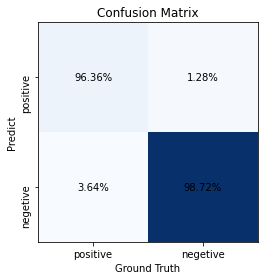

In [7]:
prob_score_all = []
prob_class_all = []
label_all = []

for i in range(5):
    weight_path = './weight/' + str(i+1) + '-resFPNCBAM' + '.pth'
    model.load_state_dict(torch.load(weight_path))
    
    test_loader_ = test_loader_list[i]

    model.eval()
    with torch.no_grad():
        for imgs, targets in tqdm(test_loader_):
            imgs = imgs.to(device)
            targets = targets.to(device)
            outputs = model(imgs)

            #计算混淆矩阵------------------------------------------------
            pred_np = np.argmax(outputs.cpu().detach().numpy(), axis=-1)
            label_np = targets.cpu().detach().numpy()
            confusionmatrix.update(pred_np, label_np)
            #------------------------------------------------------------

            prob_class_all.extend(outputs.argmax(1).cpu().numpy())
            sm = nn.Softmax(dim=1)
            pred = sm(outputs).cpu().numpy()
            pred = pred[:,1]
            prob_score_all.extend(pred)
            label_all.extend(targets.cpu().numpy())

print("AUC:{:.4f}".format(roc_auc_score(label_all,prob_score_all)))
print("F1-Score:{:.4f}".format(f1_score(label_all,prob_class_all)))
fpr, tpr, thersholds = roc_curve(label_all, prob_score_all)
confusionmatrix.draw()